In [1]:
import pandas as pd
import numpy as np
import mne
import glob
from tqdm import tqdm

from EegHelper.EegData import EegDataPoint, EegDataset, files_to_datapoints
from EegHelper.DataIO import DataBuilder, split_main_data

%matplotlib inline

#Following two are so that external files are auto loaded after edit
%load_ext autoreload
%autoreload 2
#mne outputs so much stuff, so just set log level
mne.set_log_level('error')

In [2]:
#DO NOT RUN IF YOU DO NOT WANT TO GENERATE NEW DATA
#data_path = './MindBigData-EP-v1.0/EP1.01.txt'
#split_main_data(data_path=data_path, output_folder='./MindBigData-EP-v1.0')

Load the files, get the points and the list of labels

In [2]:
files = glob.glob('./MindBigData-EP-v1.0/*.csv')
all_points, all_labels = files_to_datapoints(files, first_n=len(files)) #first_n = 500 by default. Apply first_n = len(files) to load all

100%|██████████| 65034/65034 [04:01<00:00, 269.48it/s]


In [3]:
print("Num points:", len(all_points))
print("Num labels:", len(all_labels))
print("Labels:", all_labels)

Num points: 64629
Num labels: 11
Labels: ['5', '1', '8', '-1', '7', '2', '9', '4', '6', '0', '3']


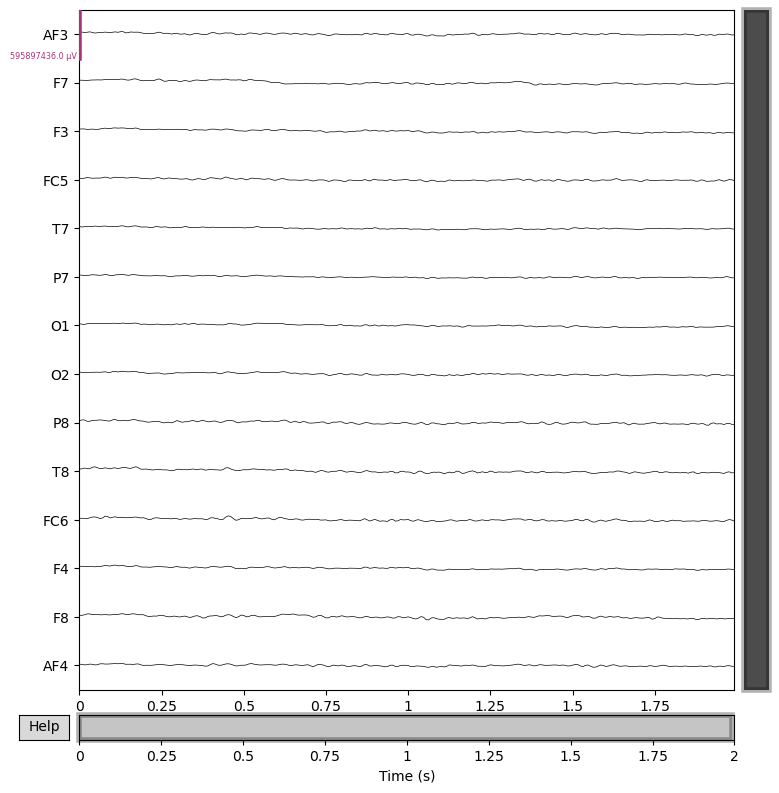

In [4]:
all_points[234].mne_object.plot(scalings = 'auto'); #Pre-cleaning

In [5]:
"""
We will loop through every data point and call the cleaning methods.
This filters the frequencies to be only between the ranges. We want 3 - 30 because this is where relevant alpha theta, beta bands lie.
MNE says to multiply the lowpass by 1/3.
"""
for point in tqdm(all_points):
    #T7, P7, P8, T8 have been shown to be the most involved in image recognition
    """point.crop_to_channels(['T7', 'P7', 'P8', 'T8'])
    point.average_reference()
    point.filter_mne(3, 30)"""
    point.full_clean(channels = ['T7', 'P7', 'P8', 'T8'], l_freq = 3, h_freq = 30)


100%|██████████| 64629/64629 [04:07<00:00, 260.92it/s]


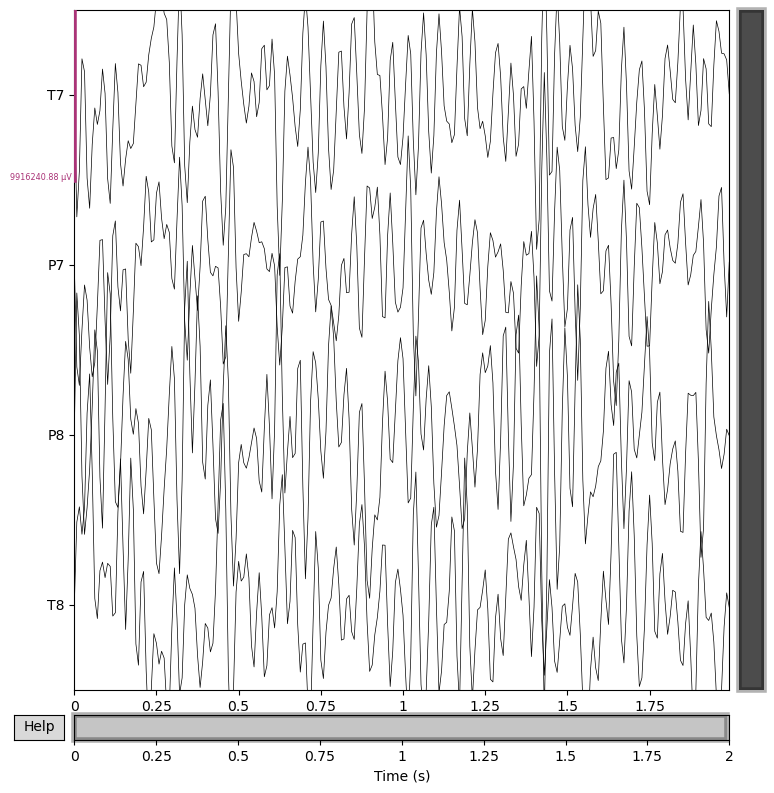

In [6]:
all_points[234].mne_object.plot(scalings='auto');

Autoencoder with the goal of anomally detection.

In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
from torch.optim import Adam
import torch.nn as nn
from torch.nn import MSELoss, CrossEntropyLoss
from EegAutoencoder import Encoder, Decoder, Autoencoder
from tqdm.notebook import tqdm

In [8]:
batch_size = 64
num_workers = 5

dataset = EegDataset(data_points=all_points, labels=all_labels)
train, test = train_test_split(dataset, train_size=0.8, shuffle=True)

train_dataloader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [9]:
input = next(train_dataloader.__iter__())[0]
input.shape

torch.Size([64, 1, 256, 4])

In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

encoder = Encoder()
decoder = Decoder()

model = Autoencoder(decoder=decoder, encoder=encoder, device=device).to(device=device)

optimizer = Adam(model.parameters(), lr=0.001)
loss_function = MSELoss()

n_epochs = 20

for epoch in range(n_epochs):
    
    print(f'Epoch {epoch+1}/{n_epochs}')
    model.train()
    train_loss = 0.0

    for data, label in tqdm(train_dataloader):
        
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = loss_function(output, data)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data*data.size(0)
    
    train_loss/=len(train_dataloader)
    
    print('Epoch Loss:', train_loss)


cpu
Epoch 1/20


  0%|          | 0/808 [00:00<?, ?it/s]